# Chameleon Cast - Iteration 2: First & Last Frame Conditioning

This iteration adds visual grounding by using the first and last frames from the original video as reference images for Veo.

In [ ]:
!pip install -q -U google-generativeai
!pip install yt_dlp opencv-python-headless pillow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.0/180.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 50.3 MB/s eta 0:00:00


In [ ]:
import google.generativeai as genai
from google.colab import userdata
from google import genai as genai_client
import yt_dlp
import time
import json
import cv2
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')
genai.configure(api_key=GOOGLE_API_KEY)
client = genai_client.Client(api_key=GOOGLE_API_KEY)

In [ ]:
# Video URL
yt_url = 'https://www.youtube.com/shorts/5gAlaBHEXrA'

## Step 1: Download and Upload Video

In [ ]:
# Download the video
ydl_opts = {'format': 'best', 'outtmpl': 'video.mp4'}
with yt_dlp.YoutubeDL(ydl_opts) as ydl:
    ydl.download([yt_url])

# Upload the video to Gemini
print("Uploading video...")
video_file = genai.upload_file(path="video.mp4")

# Wait for processing
print("Waiting for video to be processed...")
while video_file.state.name == "PROCESSING":
    time.sleep(2)
    video_file = genai.get_file(video_file.name)

if video_file.state.name == "FAILED":
    raise ValueError(f"Video processing failed: {video_file.state.name}")

print(f"Video is ready! State: {video_file.state.name}")

[youtube] Extracting URL: https://www.youtube.com/shorts/5gAlaBHEXrA
[youtube] 5gAlaBHEXrA: Downloading webpage


[youtube] 5gAlaBHEXrA: Downloading android sdkless player API JSON
[youtube] 5gAlaBHEXrA: Downloading web safari player API JSON


[youtube] 5gAlaBHEXrA: Downloading m3u8 information


[info] 5gAlaBHEXrA: Downloading 1 format(s): 301-11
[download] video.mp4 has already been downloaded
[download] 100% of    5.24MiB
Uploading video...
Waiting for video to be processed...
Video is ready! State: ACTIVE


## Step 2: Extract First and Last Frames

We'll grab the opening and closing frames to use as visual references.

Video info: 60.00 fps, 722 frames, 12.03s duration
✓ Extracted frame at 0.00s (frame 0)
✓ Extracted frame at 11.93s (frame 716)


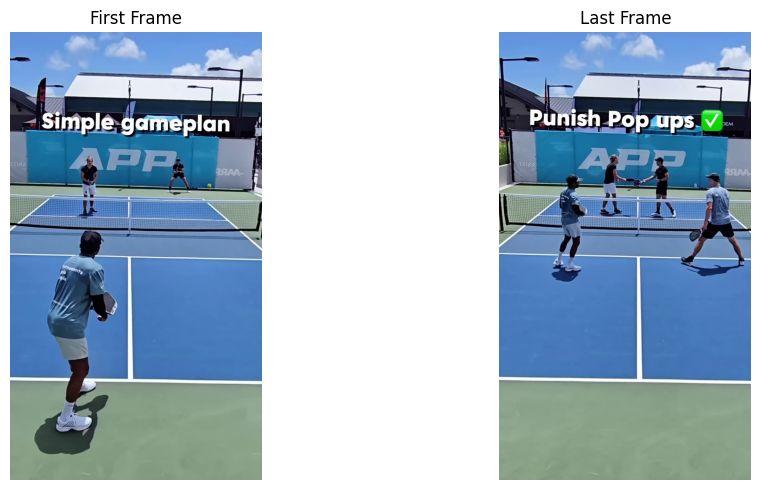

In [ ]:
def extract_frames(video_path, frame_times=None):
    """
    Extract frames at specific times from video.

    Args:
        video_path: Path to video file
        frame_times: List of times in seconds, or None for [first, last]

    Returns:
        List of PIL Images
    """
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = total_frames / fps

    print(f"Video info: {fps:.2f} fps, {total_frames} frames, {duration:.2f}s duration")

    if frame_times is None:
        # Default: first and last frame
        frame_times = [0, duration - 0.1]  # Slightly before end to avoid black frames

    frames = []
    for time_sec in frame_times:
        frame_number = int(time_sec * fps)
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
        success, frame = cap.read()

        if success:
            # Convert BGR to RGB
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            pil_image = Image.fromarray(frame_rgb)
            frames.append(pil_image)
            print(f"✓ Extracted frame at {time_sec:.2f}s (frame {frame_number})")
        else:
            print(f"✗ Failed to extract frame at {time_sec:.2f}s")

    cap.release()
    return frames

# Extract first and last frames
frames = extract_frames('video.mp4')
first_frame = frames[0]
last_frame = frames[1]

# Save frames
first_frame.save('first_frame.png')
last_frame.save('last_frame.png')

# Display frames
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(first_frame)
axes[0].set_title('First Frame')
axes[0].axis('off')
axes[1].imshow(last_frame)
axes[1].set_title('Last Frame')
axes[1].axis('off')
plt.tight_layout()
plt.show()

## Step 3: Extract Structured JSON Description

Same as Iteration 1 - get JSON structure from Gemini.

In [ ]:
model = genai.GenerativeModel('gemini-2.5-flash-lite')

json_prompt = """Analyze this video and return a JSON structure describing it for animation generation.

IMPORTANT: Return ONLY valid JSON, no markdown code blocks or extra text.

Use this exact structure:
{
  "style": {
    "animation_type": "string (e.g., Pixar 3D, Disney 2D, stop-motion)",
    "color_palette": "string describing colors",
    "mood": "string describing tone/feeling"
  },
  "scene": {
    "setting": "string describing location",
    "lighting": "string describing light quality",
    "camera": "string describing camera angles/movement"
  },
  "characters": [
    {
      "species": "animated animal species",
      "appearance": "physical description and clothing",
      "personality": "character traits shown"
    }
  ],
  "actions": [
    {
      "timestamp": "time range (e.g., 0-2s)",
      "description": "what happens in this segment",
      "camera_focus": "what the camera emphasizes"
    }
  ],
  "audio_cues": [
    "list of important sounds or dialogue"
  ]
}

Requirements:
- Replace all humans with appropriate animated animal characters
- Keep the same actions and energy
- Make it suitable for Pixar/Disney style animation
- Break down actions into 2-second segments
- Return ONLY the JSON, nothing else
"""

response = model.generate_content([json_prompt, video_file])
response_text = response.text.strip()

# Clean up response if it has markdown code blocks
if response_text.startswith('```json'):
    response_text = response_text.replace('```json', '').replace('```', '').strip()
elif response_text.startswith('```'):
    response_text = response_text.replace('```', '').strip()

print("Raw JSON Response:")
print(response_text)
print("\n" + "="*50 + "\n")

Raw JSON Response:
{
  "style": {
    "animation_type": "Pixar 3D",
    "color_palette": "Bright blues and greens for the court, white and grey for clothing, clear blue sky with fluffy white clouds",
    "mood": "Energetic, competitive, friendly"
  },
  "scene": {
    "setting": "Outdoor pickleball court with a net, surrounded by green areas and some buildings/tents in the background.",
    "lighting": "Bright, sunny daylight with clear shadows.",
    "camera": "Dynamic camera angles, mostly from a low perspective behind the players, with some wider shots and close-ups on the ball and paddles. Occasional panning and tilting to follow the action."
  },
  "characters": [
    {
      "species": "Golden Retriever",
      "appearance": "Wearing a light blue t-shirt with text on the back, light grey shorts, and white athletic shoes. Has a black baseball cap.",
      "personality": "Focused, agile, enthusiastic."
    },
    {
      "species": "Beagle",
      "appearance": "Wearing a dark t-sh

In [ ]:
try:
    video_json = json.loads(response_text)
    print("✅ JSON parsed successfully!\n")
    print(json.dumps(video_json, indent=2))
except json.JSONDecodeError as e:
    print(f"❌ JSON parsing failed: {e}")
    print("Attempting to fix...")
    import re
    json_match = re.search(r'\{.*\}', response_text, re.DOTALL)
    if json_match:
        video_json = json.loads(json_match.group())
        print("✅ JSON extracted and parsed!\n")
        print(json.dumps(video_json, indent=2))
    else:
        raise

✅ JSON parsed successfully!

{
  "style": {
    "animation_type": "Pixar 3D",
    "color_palette": "Bright blues and greens for the court, white and grey for clothing, clear blue sky with fluffy white clouds",
    "mood": "Energetic, competitive, friendly"
  },
  "scene": {
    "setting": "Outdoor pickleball court with a net, surrounded by green areas and some buildings/tents in the background.",
    "lighting": "Bright, sunny daylight with clear shadows.",
    "camera": "Dynamic camera angles, mostly from a low perspective behind the players, with some wider shots and close-ups on the ball and paddles. Occasional panning and tilting to follow the action."
  },
  "characters": [
    {
      "species": "Golden Retriever",
      "appearance": "Wearing a light blue t-shirt with text on the back, light grey shorts, and white athletic shoes. Has a black baseball cap.",
      "personality": "Focused, agile, enthusiastic."
    },
    {
      "species": "Beagle",
      "appearance": "Wearing a

## Step 4: Convert JSON to Prompt + Upload Reference Images

Now we'll create the prompt AND upload our reference frames to Veo.

In [ ]:
def json_to_prompt(video_json):
    """Convert structured JSON to a detailed video generation prompt"""

    # Build style description
    style = video_json.get('style', {})
    style_desc = f"{style.get('animation_type', 'Animated')} with {style.get('color_palette', 'vibrant colors')}. {style.get('mood', 'Energetic')} mood."

    # Build scene description
    scene = video_json.get('scene', {})
    scene_desc = f"Scene: {scene.get('setting', 'outdoor setting')} with {scene.get('lighting', 'natural lighting')}. Camera: {scene.get('camera', 'dynamic angles')}."

    # Build character descriptions
    characters = video_json.get('characters', [])
    char_desc = "Characters: " + ", ".join([
        f"{c.get('species', 'animal')} ({c.get('appearance', 'colorful')})"
        for c in characters
    ])

    # Build action sequence
    actions = video_json.get('actions', [])
    action_desc = "Action sequence: " + " ".join([
        f"[{a.get('timestamp', '')}] {a.get('description', '')}."
        for a in actions
    ])

    # Combine into final prompt
    final_prompt = f"{style_desc} {scene_desc} {char_desc} {action_desc}"

    return final_prompt

veo_prompt = json_to_prompt(video_json)
print("Generated Veo Prompt:")
print("="*50)
print(veo_prompt)
print("="*50)

Generated Veo Prompt:
Pixar 3D with Bright blues and greens for the court, white and grey for clothing, clear blue sky with fluffy white clouds. Energetic, competitive, friendly mood. Scene: Outdoor pickleball court with a net, surrounded by green areas and some buildings/tents in the background. with Bright, sunny daylight with clear shadows.. Camera: Dynamic camera angles, mostly from a low perspective behind the players, with some wider shots and close-ups on the ball and paddles. Occasional panning and tilting to follow the action.. Characters: Golden Retriever (Wearing a light blue t-shirt with text on the back, light grey shorts, and white athletic shoes. Has a black baseball cap.), Beagle (Wearing a dark t-shirt, dark shorts, and white athletic shoes. Has a dark baseball cap.), Border Collie (Wearing a white t-shirt and dark shorts, with white athletic shoes.), Poodle (Wearing a dark t-shirt and dark shorts, with white athletic shoes.) Action sequence: [0-2s] The Golden Retrieve

In [ ]:
# Upload reference frames to Gemini
print("Uploading reference frames...")
first_frame_file = client.files.upload(file='first_frame.png')
last_frame_file = client.files.upload(file='last_frame.png')
print("✅ Reference frames uploaded")

Uploading reference frames...
✅ Reference frames uploaded


## Step 5: Generate Video with Frame Conditioning

Now we'll pass both the text prompt AND the reference frames to Veo.

In [ ]:
from google.genai import types

print("Preparing reference frames...")

# Read frames as bytes
with open('first_frame.png', 'rb') as f:
    first_frame_bytes = f.read()

with open('last_frame.png', 'rb') as f:
    last_frame_bytes = f.read()

# Create Image objects
first_image = types.Image(
    image_bytes=first_frame_bytes,
    mime_type="image/png"
)

last_image = types.Image(
    image_bytes=last_frame_bytes,
    mime_type="image/png"
)

print("✅ Reference frames prepared")

Preparing reference frames...
✅ Reference frames prepared


In [ ]:
from google.genai import types

print("Generating video with Veo 3.1 + frame conditioning...")
print(f"Prompt: {veo_prompt}\n")
print("Reference frames: first_frame.png, last_frame.png\n")

# Wrap reference images
first_ref = types.VideoGenerationReferenceImage(
    image=first_image,  # Use the Image object, not File
    reference_type="asset"
)

last_ref = types.VideoGenerationReferenceImage(
    image=last_image,  # Use the Image object, not File
    reference_type="asset"
)

# Generate video
operation = client.models.generate_videos(
    model="veo-3.1-generate-preview",
    prompt=veo_prompt,
    config=types.GenerateVideosConfig(
        reference_images=[first_ref, last_ref],
        number_of_videos=1,
        resolution="720p"
    )
)

# Wait for completion
while not operation.done:
    print("Waiting for video generation to complete...")
    time.sleep(10)
    operation = client.operations.get(operation)

# Download result
generated_video = operation.response.generated_videos[0]
client.files.download(file=generated_video.video)
generated_video.video.save("iteration2_frames_output.mp4")
print("\n✅ Generated video saved to iteration2_frames_output.mp4")

Generating video with Veo 3.1 + frame conditioning...
Prompt: Pixar 3D with Bright blues and greens for the court, white and grey for clothing, clear blue sky with fluffy white clouds. Energetic, competitive, friendly mood. Scene: Outdoor pickleball court with a net, surrounded by green areas and some buildings/tents in the background. with Bright, sunny daylight with clear shadows.. Camera: Dynamic camera angles, mostly from a low perspective behind the players, with some wider shots and close-ups on the ball and paddles. Occasional panning and tilting to follow the action.. Characters: Golden Retriever (Wearing a light blue t-shirt with text on the back, light grey shorts, and white athletic shoes. Has a black baseball cap.), Beagle (Wearing a dark t-shirt, dark shorts, and white athletic shoes. Has a dark baseball cap.), Border Collie (Wearing a white t-shirt and dark shorts, with white athletic shoes.), Poodle (Wearing a dark t-shirt and dark shorts, with white athletic shoes.) Act